<a href="https://colab.research.google.com/github/swarna987456/MTech_Final_Project/blob/main/LSTM%2BAug%2BGlove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pickle

with open('train_df_augmented.pickle', 'rb') as f:
    train_df_augmented = pickle.load(f)
with open('y_train_augmented.pickle', 'rb') as f:
    y_train_augmented = pickle.load(f)
with open('X_eval.pickle', 'rb') as f:
    X_eval = pickle.load(f)
with open('y_eval.pickle', 'rb') as f:
    y_eval = pickle.load(f)

In [2]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# Load the GloVe model with 100 dimensions (much smaller than the 300-dimension Word2Vec)
wv = api.load('glove-wiki-gigaword-100')
wv.save('glove.wordvectors')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [4]:
#!pip install gensim -q
from gensim.models import KeyedVectors

In [6]:
import numpy as np

In [7]:
train_df_augmented.head()

,description,text_length,assignment_group
9244,job order scheduler monitor tool company com,43,14.0
4860,infotype exist personal phone,29,NaN
10424,erp consignment issue create duplicate order g...,118,3.0
11752,order drop ship inwarehouse tool customer item...,169,3.0
1157,solidwork simulation provide detail support be...,83,NaN


In [8]:
import pandas as pd
X = pd.concat([train_df_augmented['description'], X_eval['description']])
y = pd.concat([y_train_augmented, y_eval])

In [9]:
from sklearn.model_selection import train_test_split

In [44]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, padding='post', truncating='post')
max_sequence_length = padded_sequences.shape[1]

target = y
X_train, X_eval, y_train, y_eval = train_test_split(
    padded_sequences, target, test_size=0.2, random_state=42, stratify=target
)

embeddings_index = KeyedVectors.load("glove.wordvectors", mmap='r')

vocab_size = min(len(word_index) + 1, 5000)
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < vocab_size:  # Ensuring index is within the vocab size limit
        embedding_vector = embeddings_index.get_vector(word) if word in embeddings_index else None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),
    Bidirectional(LSTM(units=256)),
    Dropout(0.5),
    Dense(100, activation='relu'),
    Dense(len(set(target)), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=15, validation_data=(X_eval, y_eval))

loss, accuracy = model.evaluate(X_eval, y_eval)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


327/327 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - accuracy: 0.4193 - loss: 1.9287 - val_accuracy: 0.5065 - val_loss: 1.4175
Epoch 2/15
327/327 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.5557 - loss: 1.3106 - val_accuracy: 0.6251 - val_loss: 1.0840
Epoch 3/15
327/327 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.4839 - loss: 1.7126 - val_accuracy: 0.5964 - val_loss: 1.2108
Epoch 4/15
327/327 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.6077 - loss: 1.1571 - val_accuracy: 0.4189 - val_loss: 1.9645
Epoch 5/15
327/327 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.5620 - loss: 1.3338 - val_accuracy: 0.6813 - val_loss: 0.9149
Epoch 6/15
327/327 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.6827 - loss: 0.8830 - val_accuracy: 0.7223 - val_loss: 0.8045
Epoch 7/15
327/327 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.7400 - loss: 0.7446 - val_accuracy: 0.7364 - val_loss: 0.7388
Epoch 8/15
327/327 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.7718 - loss: 0.6385 - val_accurac

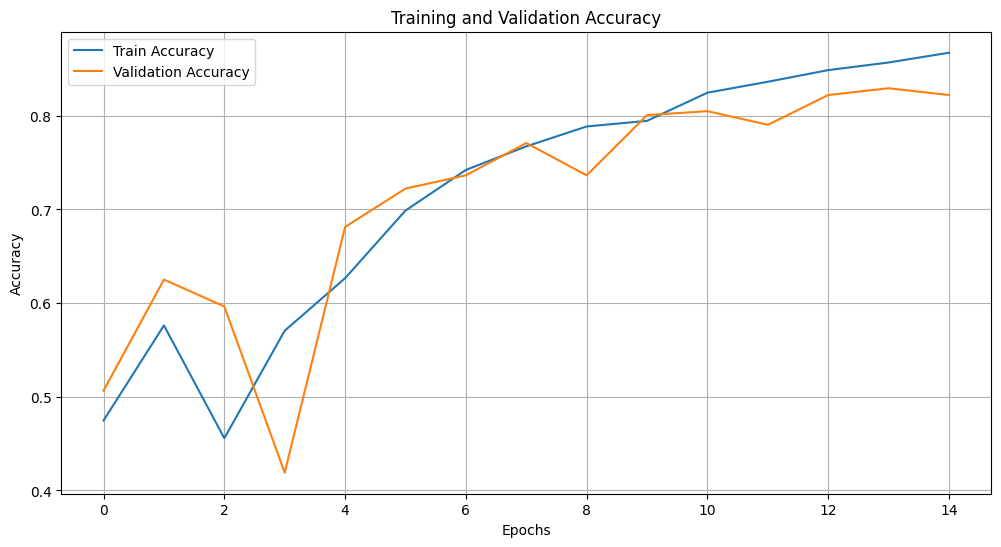

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 332, 100)            │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 512)                 │         731,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 100)                 │          51,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 16)                  │           1,616 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,852,158 (10.88 MB)

 Trainable params: 784,052 (2.99 MB)

 Non-trainable params: 500,000 (1.91 MB)

 Optimizer params: 1,568,106 (5.98 MB)

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

model.summary()

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Accuracy 0.8221117061973986
Precision 0.831787639021385
Recall 0.8221117061973986
F1-Score 0.8210658049450847
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       708
           1       0.80      0.74      0.77        86
           2       0.93      0.91      0.92       157
           3       0.82      0.94      0.88        89
           4       0.85      0.88      0.86        72
           5       0.88      0.88      0.88       131
           6       0.77      0.93      0.85       147
           7       0.82      1.00      0.90       168
           8       0.96      0.94      0.95        70
           9       0.85      0.78      0.81       122
          10       0.95      0.84      0.89        64
          11       0.94      0.84      0.89        61
          12       0.64      0.67      0.65        78
          13       0.94      0.60      0.73       112
          14       0.67      0.84      

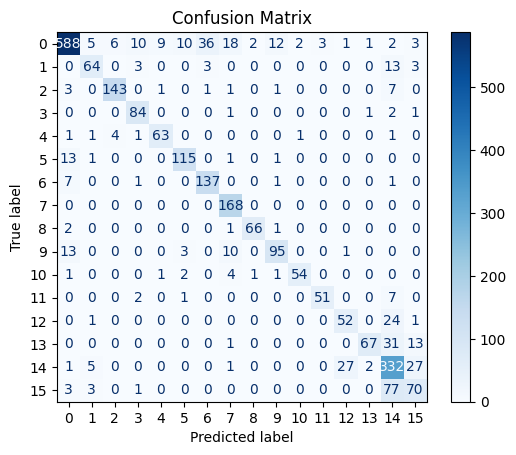

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
y_pred = model.predict(X_eval).argmax(axis=1)

print('Accuracy',accuracy_score(y_eval, y_pred))
print('Precision',precision_score(y_eval, y_pred, average='weighted'))
print('Recall',recall_score(y_eval, y_pred, average='weighted'))
print('F1-Score',f1_score(y_eval, y_pred, average='weighted'))
# Print classification report
print(classification_report(y_eval, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_eval, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [47]:
import joblib

joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(max_sequence_length, 'max_sequence_length.pkl')
joblib.dump(embedding_matrix, 'embedding_matrix.pkl')

from tensorflow.keras.saving import save_model

save_model(model, 'model.keras')

In [48]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib
import numpy as np

tokenizer = joblib.load('tokenizer.pkl')
max_sequence_length = joblib.load('max_sequence_length.pkl')
model = load_model('model.keras')

new_text = ["power outage cantabria site hard backup circuit type network specify top cert start schedule maintenance company provider maint ticket active contact notify phone email remote dial equipment reset verify work vendor global telecom verizon gsc additional diagnostic"]

new_sequences = tokenizer.texts_to_sequences(new_text)
new_padded_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

predictions = model.predict(new_padded_sequences)
predicted_class_index = np.argmax(predictions, axis=1)[0]

print(f"Predicted class index: {predicted_class_index}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Predicted class index: 14


In [49]:
predicted_class_index

14

In [50]:
import joblib

le = joblib.load('LabelEncoder.pkl')
le.inverse_transform([predicted_class_index])[0]

'GRP_8'